In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("../../raw_data/Crimes.csv")

In [3]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [4]:
df.drop(columns=["X Coordinate", "Y Coordinate", "Latitude", "Longitude", "Location", "Beat"], inplace=True)

## Community area 25


In [5]:
df_4=df.groupby("Community Area").count()
ca_df=df_4[["ID"]].rename(columns={"ID" : "crime_count" })

In [6]:
worst =  float(ca_df[ ca_df["crime_count"]==int(ca_df.max()[0]) ].index[0] )
print(f" The worst community area is Nr. {int(worst)}!")

 The worst community area is Nr. 25!


/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_96036/1255772045.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  worst =  float(ca_df[ ca_df["crime_count"]==int(ca_df.max()[0]) ].index[0] )


In [7]:
df_25=df[df["Community Area"]==worst]

In [8]:
from datetime import datetime

def timer(t):
    return datetime.strptime(t, "%m/%d/%Y %I:%M:%S %p")

In [9]:
df_25["Date_dt"]=df_25["Date"].apply(timer)

/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_96036/3525700377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_25["Date_dt"]=df_25["Date"].apply(timer)


In [10]:
df_25["Y_M"]=df_25['Date_dt'].dt.to_period('M')

/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_96036/620581492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_25["Y_M"]=df_25['Date_dt'].dt.to_period('M')


In [11]:
ca25monthly_df=df_25.groupby("Y_M").count().rename(columns={"ID" : "crime_count" })[["crime_count"]]

In [12]:
ca25monthly_df

,crime_count
Y_M,
2001-01,33
2001-02,18
2001-03,16
2001-04,16
2001-05,16
...,...
2024-04,1017
2024-05,1101
2024-06,1225


<Axes: xlabel='Y_M'>

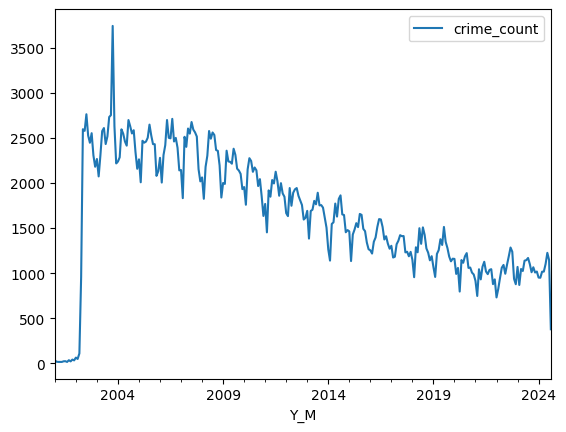

In [13]:
ca25monthly_df.plot()

## RNN model 1

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [142]:
# DATA PREPROCESS

# turn crimes into list
crime_count_list = list(ca25monthly_df["crime_count"])

# parameters
sequence_length = 12  # number of months to consider for predicting the next months

# create sequences
X, y = [], []
for i in range(sequence_length, len(crime_count_list)):
    X.append(crime_count_list[i-sequence_length:i])
    y.append(crime_count_list[i])

X = np.array(X)
y = np.array(y)

# train_test_split 
train_size = int(len(X) * 0.8)  # 80% for training
X_train_full, X_test, y_train_full, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

In [143]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [144]:
X_train_scaled=scaler.transform(X_train)

In [145]:
X_test_scaled=scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

In [146]:
from tensorflow.keras.callbacks import EarlyStopping

In [177]:
# 1- RNN Architecture

model = Sequential()

model.add(layers.Con(units=100, activation='relu', input_shape=(sequence_length,1), return_sequences=True))
#model.add(Dropout(0.1))

model.add(layers.GRU(units=100, activation='relu'))
#model.add(Dropout(0.2))

model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

# 2- Compilation
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001)) 

# 3- Fit
#es = EarlyStopping(patience=0, restore_best_weights=True)

history=model.fit(X_train_scaled, y_train, epochs=500, verbose=0, batch_size= 16 ,validation_data=(X_val_scaled,y_val)
                  #, callbacks=[es]
                 )

# 4- Predict
y_pred=model.predict(X_test_scaled) 

/Users/user/.pyenv/versions/3.10.6/envs/LW_chicago_crime_pred/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


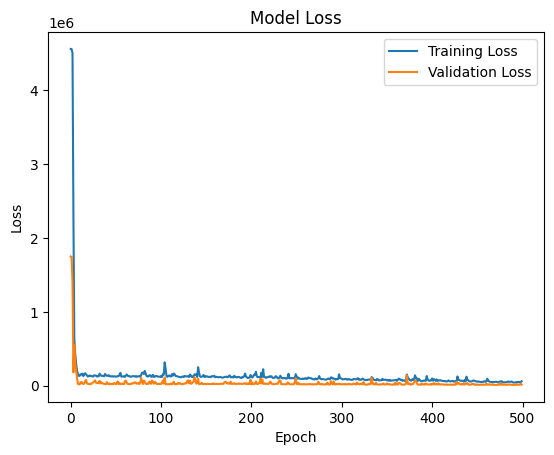

In [178]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [179]:
from sklearn.metrics import r2_score

r2_score(y_test,y_pred)

-0.8485814332962036

# TRY WEEKLY FORECAST

In [13]:
df_25["Y_W"]=df_25['Date_dt'].dt.to_period('W')

/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_96036/1990554854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_25["Y_W"]=df_25['Date_dt'].dt.to_period('W')


In [14]:
ca25weekly_df=df_25.groupby("Y_W").count().rename(columns={"ID" : "crime_count" })[["crime_count"]]

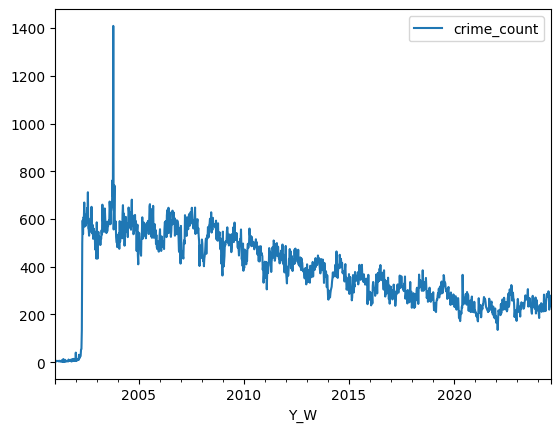

In [15]:
ca25weekly_df.plot();

In [25]:
ca25weekly_df.tail(50)

,crime_count
Y_W,
2023-08-28/2023-09-03,233
2023-09-04/2023-09-10,213
2023-09-11/2023-09-17,203
2023-09-18/2023-09-24,259
2023-09-25/2023-10-01,278
2023-10-02/2023-10-08,234
2023-10-09/2023-10-15,233
2023-10-16/2023-10-22,239
2023-10-23/2023-10-29,244


In [16]:
ca25weekly_df.shape

(1231, 1)

In [87]:
# DATA PREPROCESS

# turn crimes into list
crime_count_list = list(ca25weekly_df["crime_count"])

# parameters
sequence_length = 52  # number of weeks to consider for predicting the next week

# create sequences
X, y = [], []
for i in range(sequence_length, len(crime_count_list)):
    X.append(crime_count_list[i-sequence_length:i])
    y.append(crime_count_list[i])

X = np.array(X)
y = np.array(y)

# train_test_split 
train_size = int(len(X) * 0.8)  # 80% for training
X_train_full, X_test, y_train_full, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

In [88]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [89]:
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

In [90]:
# NN Architecture (CNN + RNN + Dense)

model = Sequential()

model.add(layers.Conv1D( filters=64, kernel_size=52, input_shape=(52, 1) ) )
#model.add(layers.MaxPool1D(pool_size=2 ) )

model.add(layers.GRU(units=64, activation='relu'
                     #, return_sequences=True
                    ))
#model.add(Dropout(0.2))

#model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

model.summary()

# 2- Compilation


/Users/user/.pyenv/versions/3.10.6/envs/LW_chicago_crime_pred/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 1, 64)          │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,409 (114.88 KB)

 Trainable params: 29,409 (114.88 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
model.compile(loss='mae', 
              optimizer=Adam(learning_rate=0.001)) 

# 3- Fit
#es = EarlyStopping(patience=0, restore_best_weights=True)

history=model.fit(X_train_scaled, y_train, epochs=300, verbose=0, batch_size= 16 ,validation_data=(X_val_scaled,y_val)
                  #, callbacks=[es]
                 )

# 4- Predict
y_pred=model.predict(X_test_scaled) 

Epoch 1/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 475.4507 - val_loss: 285.1559
Epoch 2/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 410.0444 - val_loss: 51.8659
Epoch 3/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66.1053 - val_loss: 32.0668
Epoch 4/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.8665 - val_loss: 29.9439
Epoch 5/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.1895 - val_loss: 30.5528
Epoch 6/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.2010 - val_loss: 29.4466
Epoch 7/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.6529 - val_loss: 28.2195
Epoch 8/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.1163 - val_loss: 27.4108
Epoch 9/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.0240 - val_loss: 27.8275
Epoch 10/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.0310 - val_loss: 29.3225
Epoch 11/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.5935 - val_loss: 28.3872
Epoch 12/300
45/45 ━━━━━━━━━━━━━━━━━━━

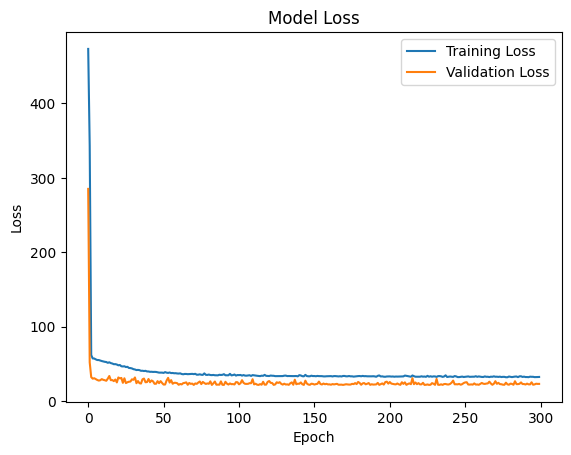

In [92]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

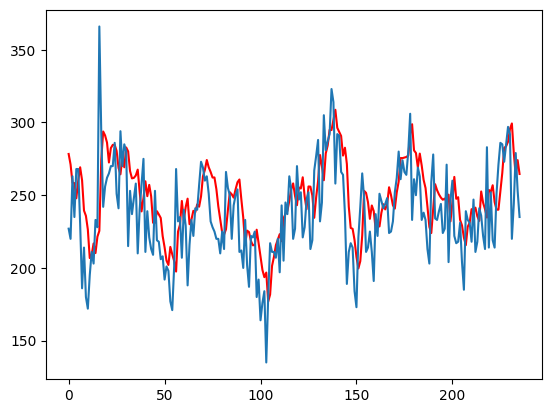

In [93]:
plt.plot(pd.DataFrame(y_pred), color= "red")
plt.plot(pd.DataFrame(y_test))

In [23]:
from sklearn.metrics import mean_absolute_error

In [40]:
mean_absolute_error(y_test,y_pred)

21.760836843716895

__FINAL REMARK/QUESTION: SHOULD HAVE SCALED THE y's AS WELL !?!?!__

let's try: DOES NOT WORK :( - somehow it is way off...

In [72]:
# generate data:
crime_count_list = list(ca25weekly_df["crime_count"])

# parameters
sequence_length = 52  # number of weeks to consider for predicting the next week

# Create sequences
X, y = [], []
for i in range(sequence_length, len(crime_count_list)):
    X.append(crime_count_list[i-sequence_length:i])
    y.append(crime_count_list[i])

X = np.array(X)
y = np.array(y)

# Train-test split
train_size = int(len(X) * 0.8)  # 80% for training
X_train_full, X_test, y_train_full, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler on X_train and transform
scaler_X.fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Fit the scaler on y_train and transform
y_train = y_train.reshape(-1, 1)  # Reshape for scaling
y_val = y_val.reshape(-1, 1)      # Reshape for scaling
y_test = y_test.reshape(-1, 1)    # Reshape for scaling

scaler_y.fit(y_train)
y_train_scaled = scaler_y.transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

# If you want to reshape y back to its original shape
y_train_scaled = y_train_scaled.flatten()
y_val_scaled = y_val_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

# Now, X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled are ready for training.

In [80]:
# NN Architecture (CNN + RNN + Dense)

model = Sequential()

model.add(layers.Conv1D( filters=64, kernel_size=52, input_shape=(52, 1) ) )
#model.add(layers.MaxPool1D(pool_size=2 ) )

model.add(layers.GRU(units=64, activation='relu'
                     #, return_sequences=True
                    ))
#model.add(Dropout(0.2))

#model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

model.summary()


/Users/user/.pyenv/versions/3.10.6/envs/LW_chicago_crime_pred/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1, 64)          │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,409 (114.88 KB)

 Trainable params: 29,409 (114.88 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
#compile

model.compile(loss='mae', 
              optimizer=Adam(learning_rate=0.001)) 

# es

#es = EarlyStopping(patience=0, restore_best_weights=True)

#fit

history=model.fit(X_train_scaled, y_train_scaled, epochs=300, verbose=0, batch_size= 16 ,validation_data=(X_val_scaled,y_val_scaled)
                  #, callbacks=[es]
                 )

# and predict
y_pred=model.predict(X_test_scaled) 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


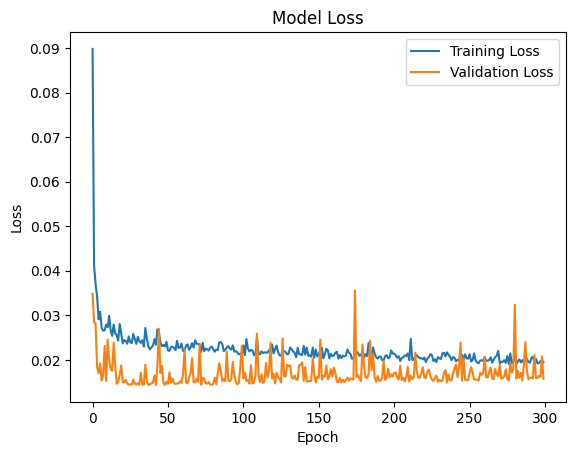

In [82]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

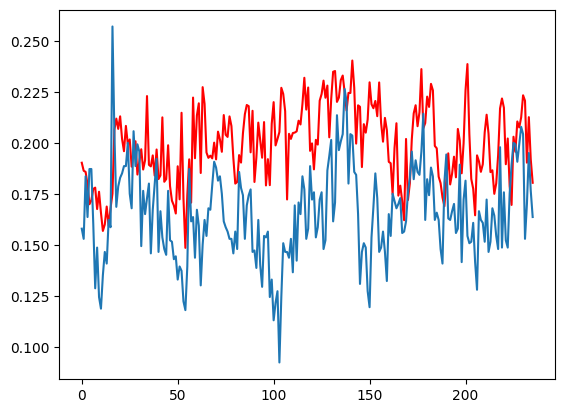

In [83]:
plt.plot(pd.DataFrame(y_pred), color= "red")
plt.plot(pd.DataFrame(y_test_scaled))

In [84]:
mean_absolute_error(y_test_scaled,y_pred)

0.03589475527549648

In [86]:
mean_absolute_error(scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1) ), scaler_y.inverse_transform(y_pred.reshape(-1, 1)) )

50.39624165680449